# Ch 6. Mixture Models

1. Finite mixture models
2. Infinite mixture models
3. Continuous mixture models

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
from scipy import stats

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = 'retina'

## Mixture models (MM)

- occurs when the population is a combination of sub-populations
- do not really have to believe there are sub-populations
    - can be used as a trick to add flexibility to the model

## Finite mixture models

- a finite weighted mixture of two or more distributions
- the probability density of the observed data is a weighted sum of the probability density for $K$ subgroups
    - $w_i$: wieght of each subgroup (a.k.a component); the probability of component $i$
    - $\Pr(y|\theta)_i$: distribution of the subgroup $i$

$$
\Pr(y|\theta) = \sum_{i=1}^{K} w_i \Pr_i(y | \theta_i)
$$

- to solve a MM, need to properly assign each data point to one of the components
    - introduce a random variable $z$ that specifies to which component an observation belongs
        - called a *latent* variable
- example using chemical shift data (from protein NMR)

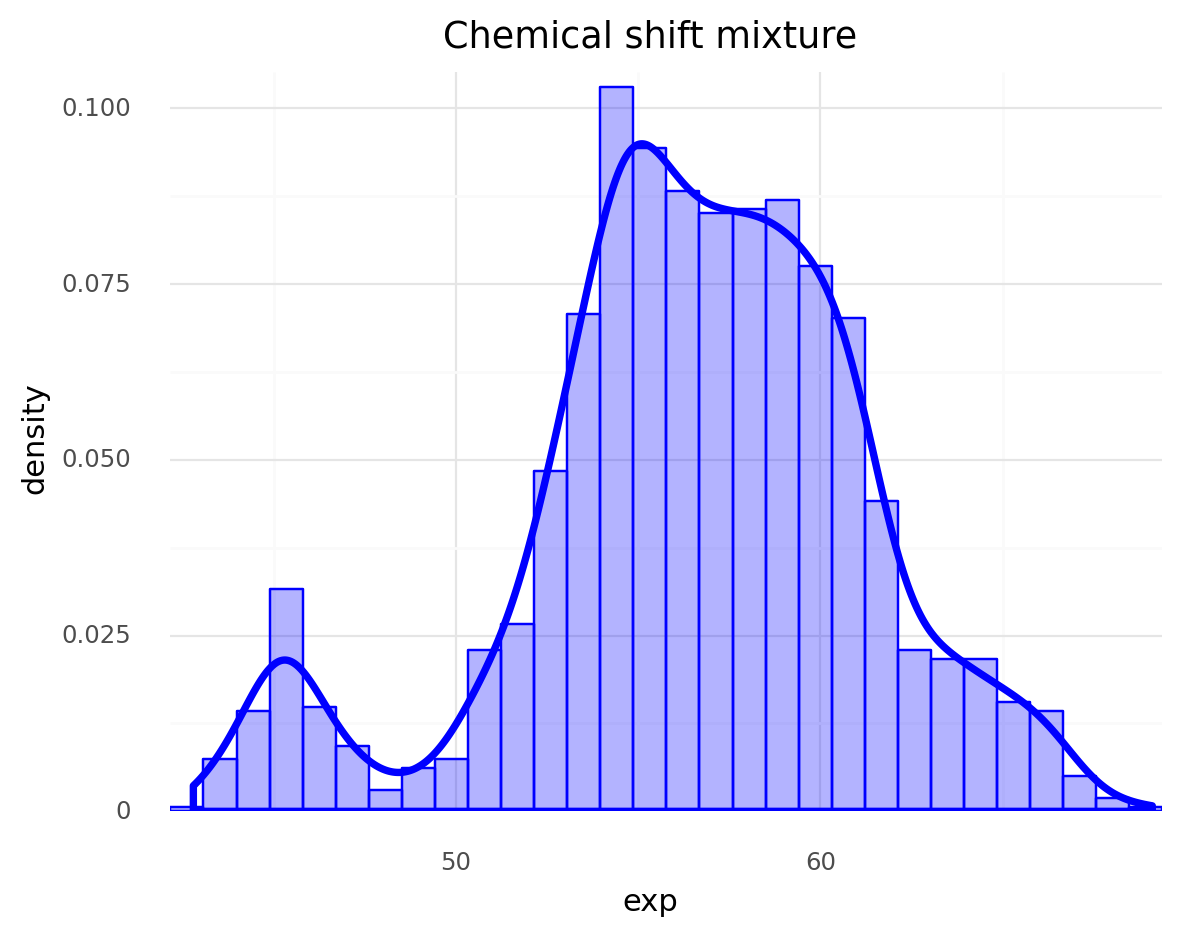

<ggplot: (8767949462122)>

In [2]:
cs = pd.read_csv(Path("data/chemical_shifts_theo_exp.csv"))
cs_exp = cs["exp"]

(
    gg.ggplot(cs, gg.aes("exp"))
    + gg.geom_histogram(
        gg.aes(y="..density.."), bins=30, alpha=0.3, fill="blue", color="blue"
    )
    + gg.geom_density(color="blue", size=1.5)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(x="exp", y="density", title="Chemical shift mixture")
)

### The categorical distribution

- most general discrete distribution
- parameterized using a parameter specifying the probabilities of each possible outcome

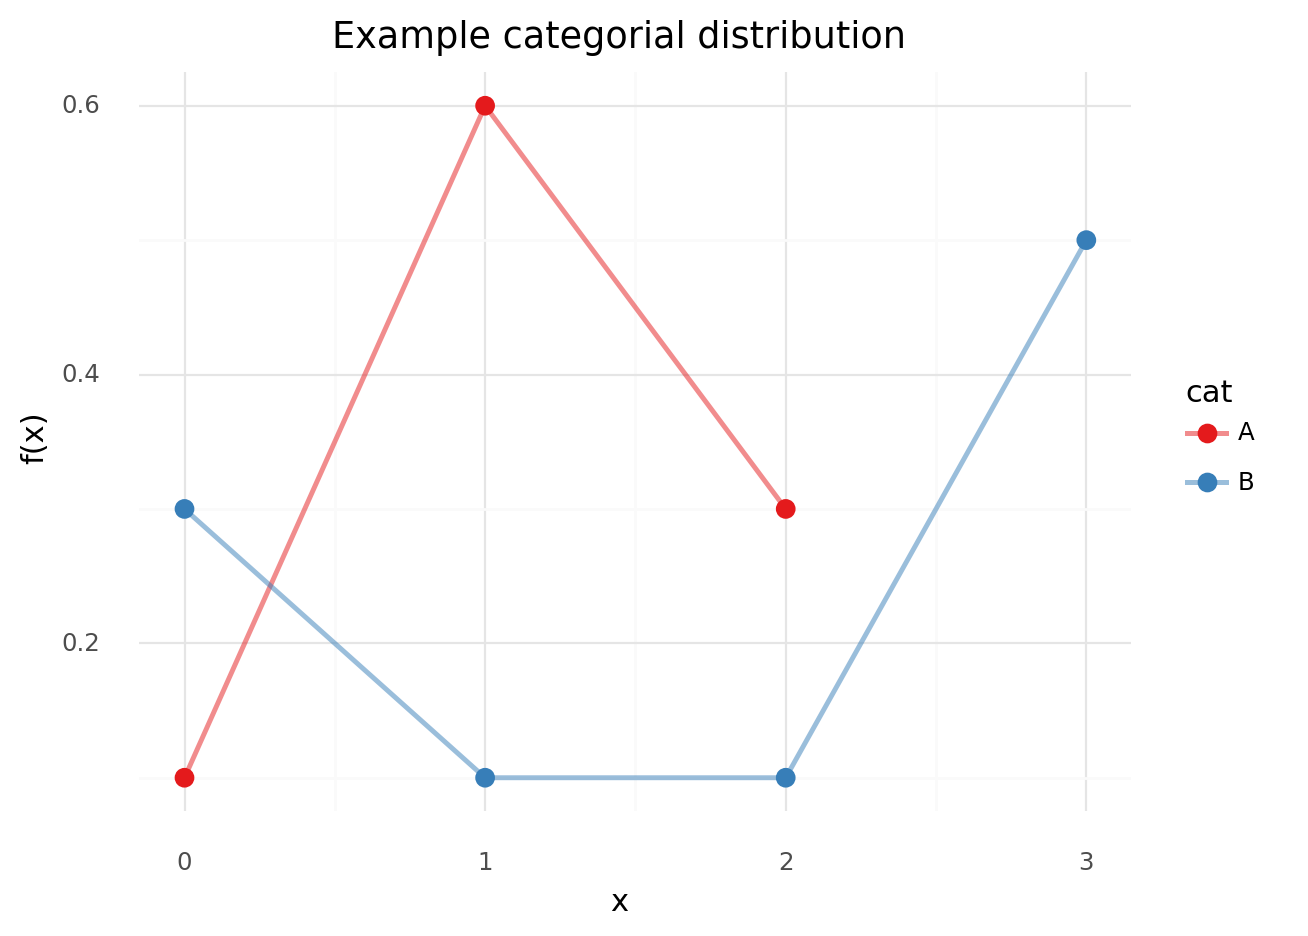

<ggplot: (8767949462101)>

In [3]:
example_cat_data = pd.DataFrame(
    {
        "cat": ["A", "A", "A", "B", "B", "B", "B"],
        "y": [0.1, 0.6, 0.3, 0.3, 0.1, 0.1, 0.5],
        "x": [0, 1, 2, 0, 1, 2, 3],
    }
)

(
    gg.ggplot(example_cat_data, gg.aes(x="x", y="y", color="cat"))
    + gg.geom_line(alpha=0.5, size=1)
    + gg.geom_point(size=3)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="x", y="f(x)", title="Example categorial distribution")
)

### The Dirichlet distribution

- the Dirichlet distribution:
    - lives in the *simplex* (an $n$-dim. triangle)
    - output of the dist. is a $K$-length vector $\alpha$
    - output are restricted to be nonnegative and sum to 1
    - generalization of the beta distribution
        - i.e. extend the beta dist. beyond 2 outcomes
        - the beta dist. has two outcomes and returns a 2-element vector: $(p, 1-p)$
        - for 3 outcomes, need a 3-element vector $(p, q, r)$ where $p+q+r=1$
        - for $K$ outcomes, declare a vector $\alpha$ where $||\alpha|| = K$

![](assets/ch06/Dirichlet-triangles.png)

- in a model, use the Dirichlet dist. as a $K$-sided coin flip model on top of a Gaussian estimated model
    - in the diagram, there are $K$ copies of the model in the rounded-rect
    - $\mu_k$ is dependent upon the group $k$
    - $\sigma_\mu$ and $\sigma_\sigma$ are shared for all groups

![](assets/ch06/Dirichlet-prior-mixture-model.png)

In [4]:
# NOTE: We expect this  model to fit poorly.
# See below for an example of how to reparameterize for a more
# effective fitting process.

clusters = 2

with pm.Model() as model_kg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    z = pm.Categorical(
        "z", p=p, shape=len(cs.exp)
    )  # group assignment; one per data point
    means = pm.Normal("means", mu=cs.exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)

    y = pm.Normal("y", mu=means[z], sd=sd, observed=cs.exp)
    # trace_kg = pm.sample()  # NOT RUN BECAUSE TOOOOOOO SLOW

- the above model fits poorly because the latent variable `z` is explcitly included
- reparameterize:
    - in a MM, the observed vairable $y$ is conditional on the latent variable $z$, that is $\Pr(y|z, \theta)$
    - can consider $z$ is nuisance variable and marginalize to get $\Pr(y | \theta)$
    - can do this in PyMC3 using the `NormalMixture()` distribution to get a Gaussian mixture model

In [5]:
clusters = 2

with pm.Model() as model_mg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal("means", mu=cs.exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)

    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs.exp)

    trace_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [6]:
az_trace_mg = az.from_pymc3(trace_mg, model=model_mg)

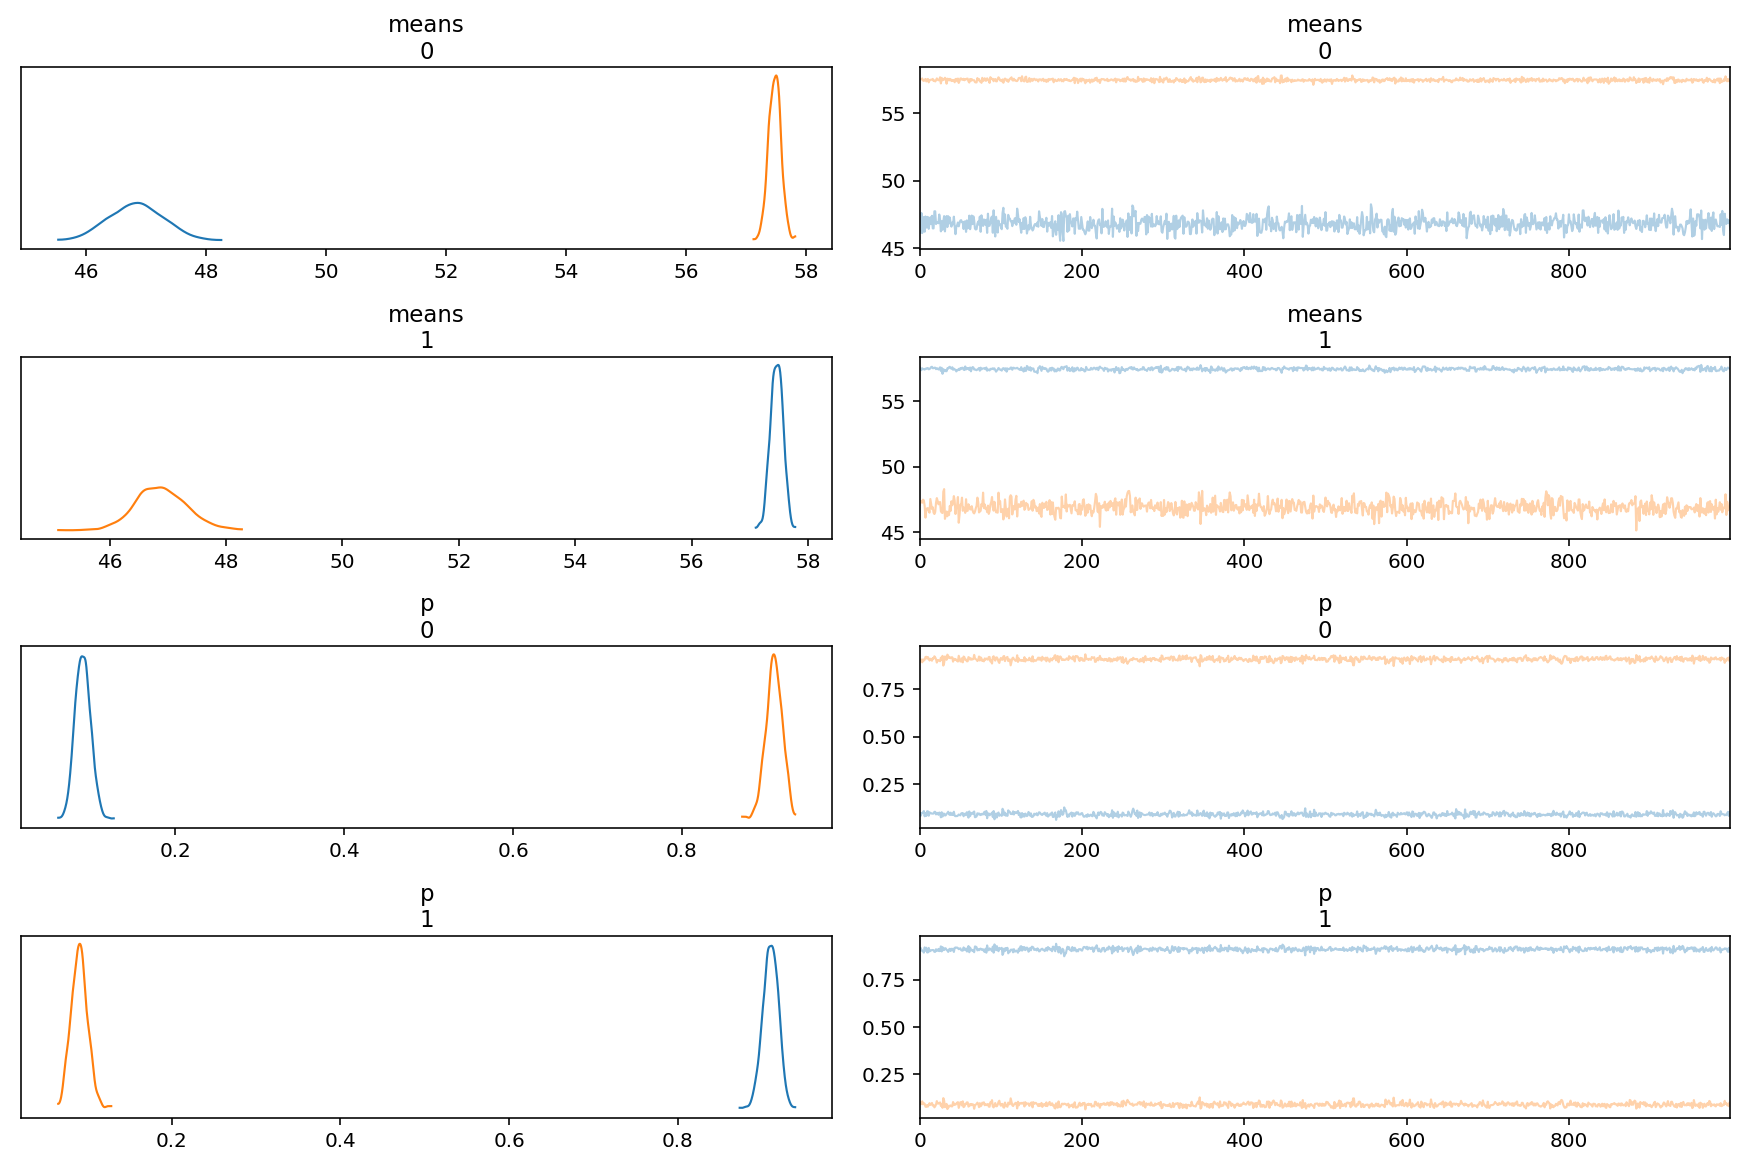

In [7]:
az.plot_trace(az_trace_mg, var_names=["means", "p"])
plt.show()

In [8]:
az.summary(trace_mg, var_names=["means", "p"])

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],52.154,5.329,46.242,57.681,3.747,3.169,2.0,2.0,3.0,63.0,1.83
means[1],52.174,5.299,46.358,57.664,3.726,3.152,2.0,2.0,3.0,61.0,1.83
p[0],0.500,0.410,0.076,0.924,0.288,0.244,2.0,2.0,3.0,93.0,1.83
p[1],0.500,0.410,0.076,0.924,0.288,0.244,2.0,2.0,3.0,93.0,1.83


### Non-identifiability of mixture models

- looking at the trace plots and summary table above, notive that the distributions for *both* means and both $p$ are bimodal and that the average values for these parameters are the same
    - caused by **parameter non-identifiability** because can make multiple different models where one mean is the either mode and the other is the remaining mode (and the same for $p$)
    - in mixture models, also known as **lbel-switching problem**
    - two ways to prevent non-identifiability in MM:
        1. force the component sto be ordered (e.g. arrange the means of the components in increasing order)
        2. use informative priors
- in PyMC3, can add `pm.potential()` to the likelihood of the model
    - is an arbitrary factor that does not necessarily depend on the data
    - thus, does not add any parameters to the model
    - example of adding a constraing to a model:
        - if the constraint is not violation, add 0 to the likelihood
        - if is violated, add $-\infty$ to make the outcome impossible
        - thus, the model considers parameters that violate the constraints to be impossible without affecting the rest of the values

In [9]:
clusters = 2

with pm.Model() as model_mgp:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal(
        "means", mu=np.array([0.9, 1]) * cs_exp.mean(), sd=10, shape=clusters
    )
    sd = pm.HalfNormal("sd", sd=10)
    order_means = pm.Potential(
        "order_means", tt.switch(means[1] - means[0] < 0, -np.inf, 0)
    )
    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mgp = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


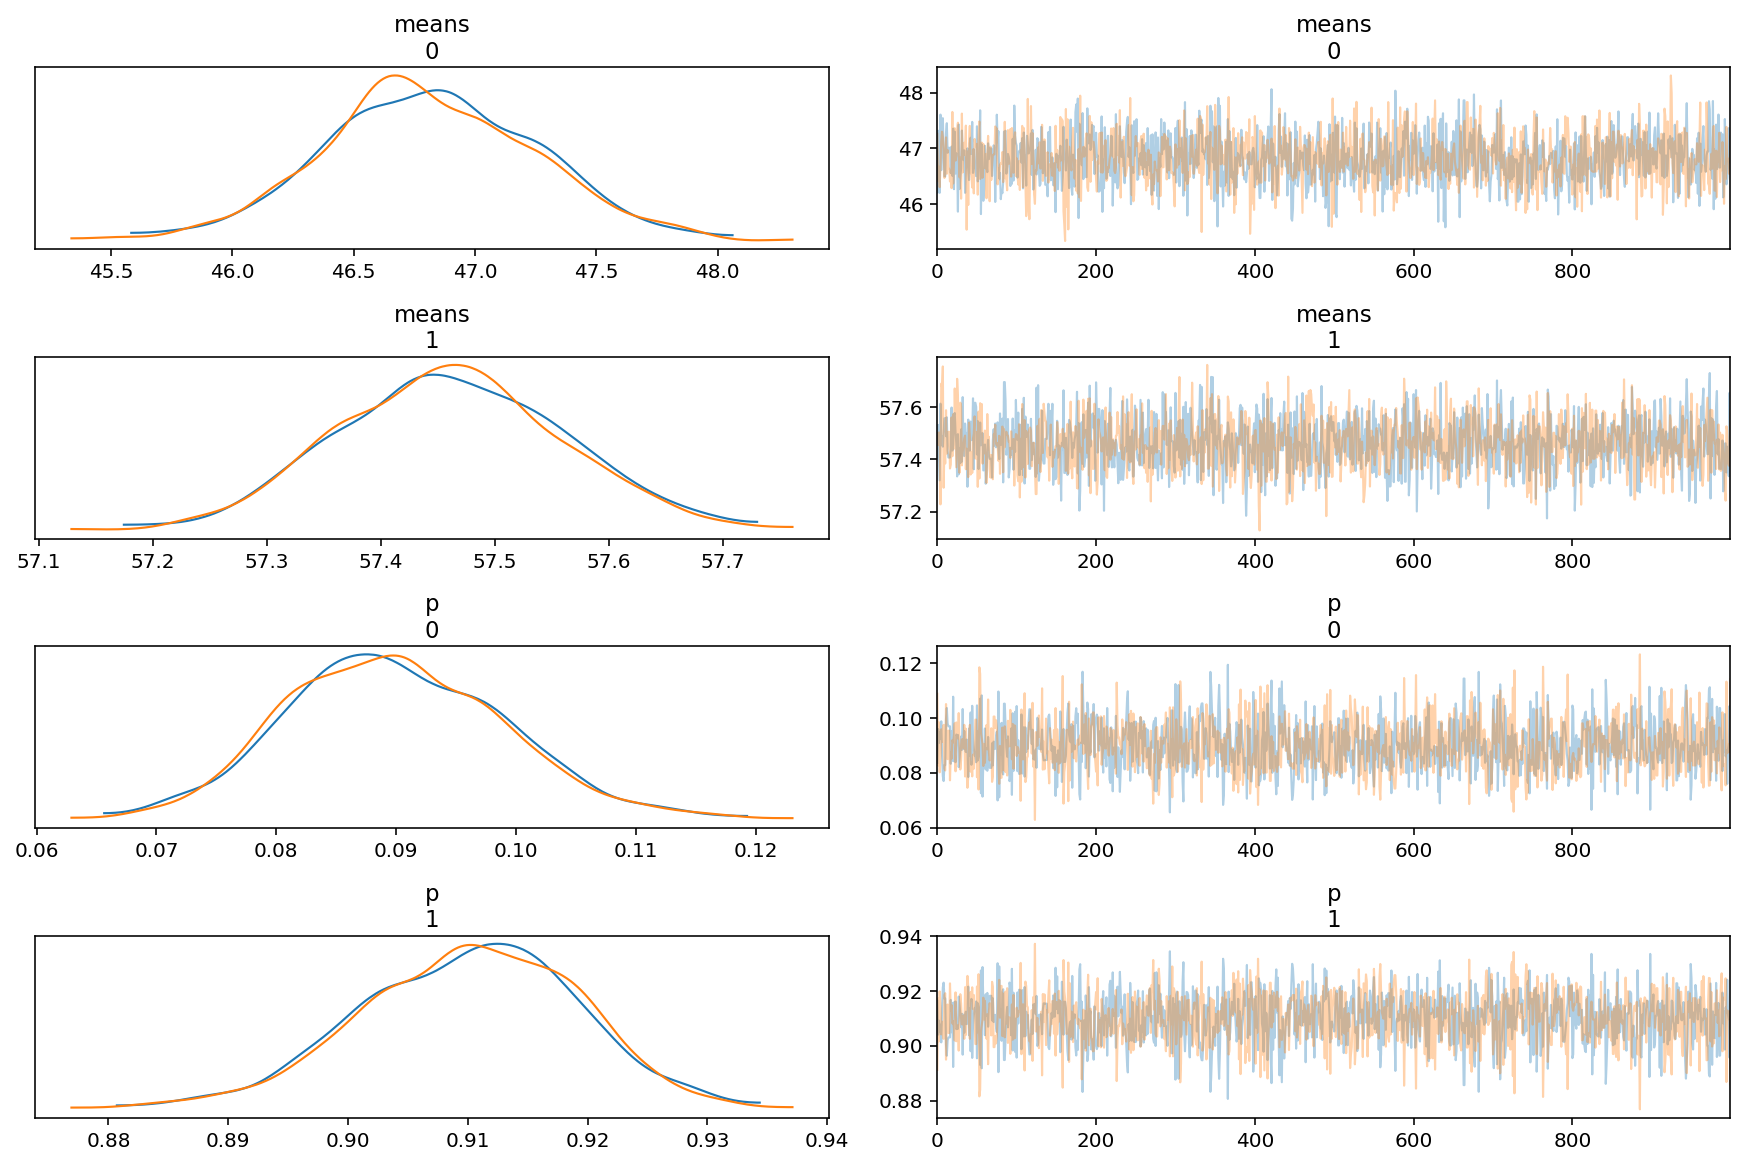

In [10]:
varnames = ["means", "p"]
az.plot_trace(trace_mgp, varnames)
plt.show()

In [11]:
az.summary(trace_mgp)

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],46.811,0.438,46.040,47.687,0.009,0.007,2185.0,2185.0,2188.0,1432.0,1.0
means[1],57.461,0.098,57.290,57.650,0.002,0.001,2255.0,2255.0,2253.0,1686.0,1.0
p[0],0.090,0.009,0.072,0.106,0.000,0.000,1818.0,1818.0,1804.0,1639.0,1.0
p[1],0.910,0.009,0.894,0.928,0.000,0.000,1818.0,1817.0,1804.0,1639.0,1.0
sd,3.651,0.074,3.506,3.788,0.002,0.001,2236.0,2222.0,2267.0,1619.0,1.0


- can also add a constraint to ensure that each component has a non-null probability
    - i.e. that each component gets at least one observation

```python
min_p = 0.01
p_min = pm.Potential("p_min", tt.switch(tt.min(p) < min_p, -np.inf, 0))
```

### How to choose K

- general advice: start small and increase to imprive model-fit
- example: compare fit of model with $K = \{3, 4, 5, 6\}$

In [16]:
clusters = [3, 4, 5, 6]

models = []
traces = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet("p", a=np.ones(cluster))
        means = pm.Normal(
            "means",
            mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
            sd=10,
            shape=cluster,
            transform=pm.distributions.transforms.ordered,
        )
        sd = pm.HalfNormal("sd", sd=10)

        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)

        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 58 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 54 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 79 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 135 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


- to show how $K$ affects inference, compare these models' fits with the one from kernel density estimation

In [80]:
trace = traces[0]


def sample_ppc(trace, x_):
    idx = np.random.randint(0, len(trace))
    means_y = trace["means"][idx]
    p_y = trace["p"][idx]
    sd = trace["sd"][idx]
    dist = stats.norm(means_y, sd)
    y = np.sum(dist.pdf(x_) * p_y, 1)
    return y


def sample_ppcs(trace, x, n_clusters, n=50):
    x_ = np.array([x] * n_clusters).T
    data = {i: sample_ppc(trace, x_) for i in range(n)}
    data = pd.DataFrame(data)
    data["x"] = x
    data = data.melt(id_vars="x", var_name="sample_idx", value_name="y")
    return data


def sample_ppc_per_cluster(trace, x, n_clusters):
    x_ = np.array([x] * n_clusters).T
    means_y = trace["means"].mean(0)
    p_y = trace["p"].mean(0)
    sd = trace["sd"].mean(0)
    dist = stats.norm(means_y, sd)
    y = dist.pdf(x_) * p_y
    data = pd.DataFrame(y)
    data["x"] = x
    data = data.melt(id_vars="x", var_name="cluster", value_name="y")
    data["cluster"] = data["cluster"].astype(str)
    return data

In [81]:
def plot_mixture_model_ppc(sampled_ppc, cluster_ppc, n_clusters):
    summary_ppc_df = sampled_ppc.groupby("x").mean().reset_index(drop=False)
    p = (
        gg.ggplot(sampled_ppc, gg.aes(x="x", y="y"))
        + gg.geom_line(gg.aes(group="sample_idx"), alpha=0.2, color="#1075B7")
        + gg.geom_line(data=summary_ppc_df, color="#004B8D", size=1, linetype="--")
        + gg.geom_line(gg.aes(group="cluster"), data=cluster_ppc, linetype="--")
        + gg.theme(figure_size=(4, 4))
        + gg.labs(
            x="exp",
            y="expected density",
            title=f"Mixture Model with {n_clusters} clusters",
        )
    )
    return p

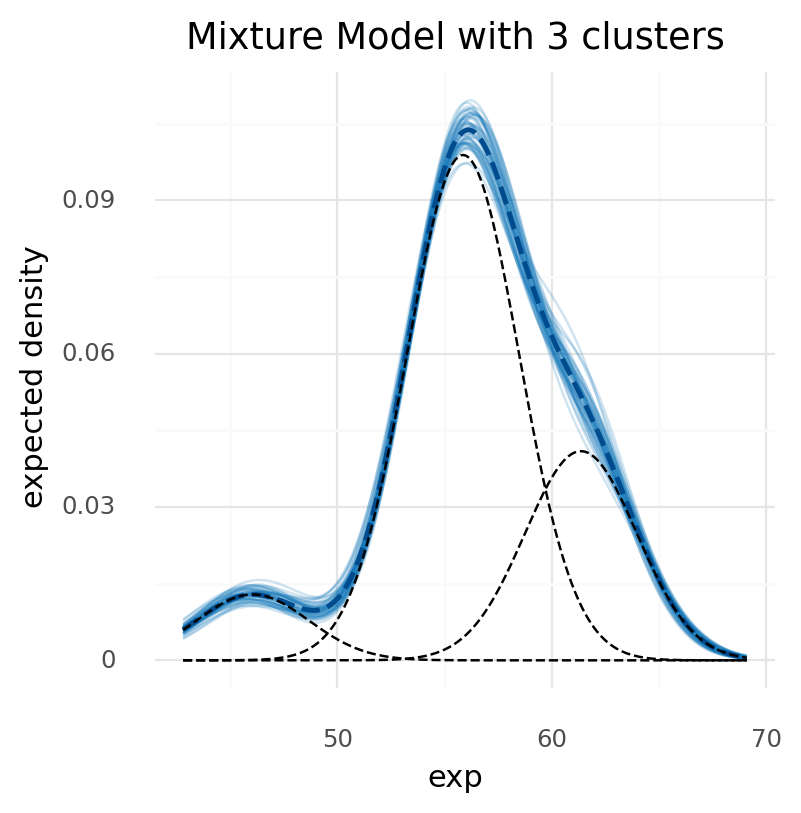

<ggplot: (8767943494705)>


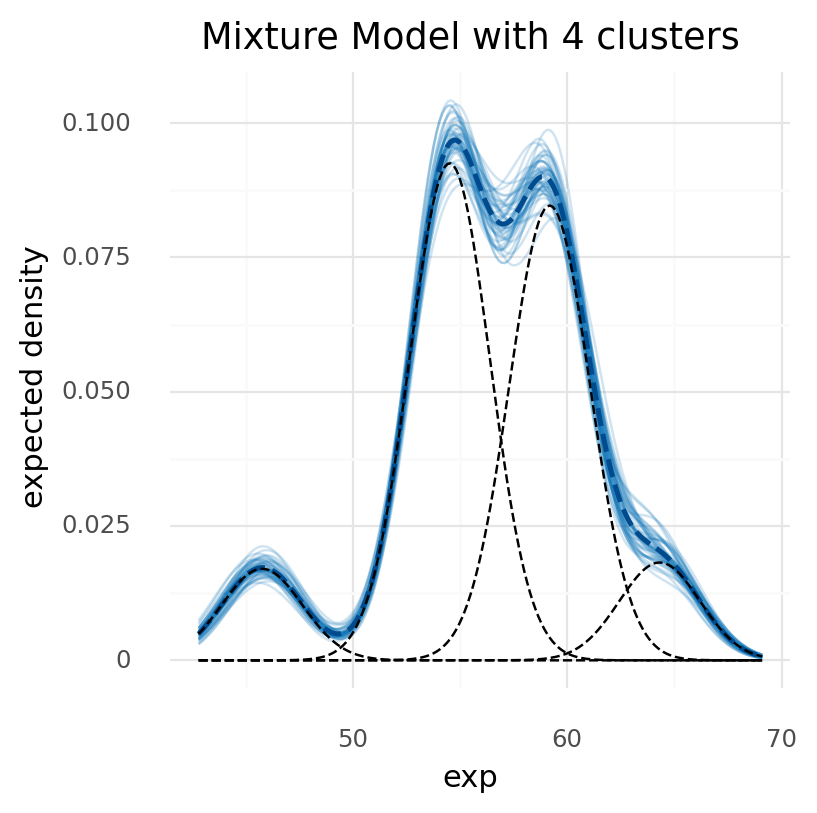

<ggplot: (8767945232782)>


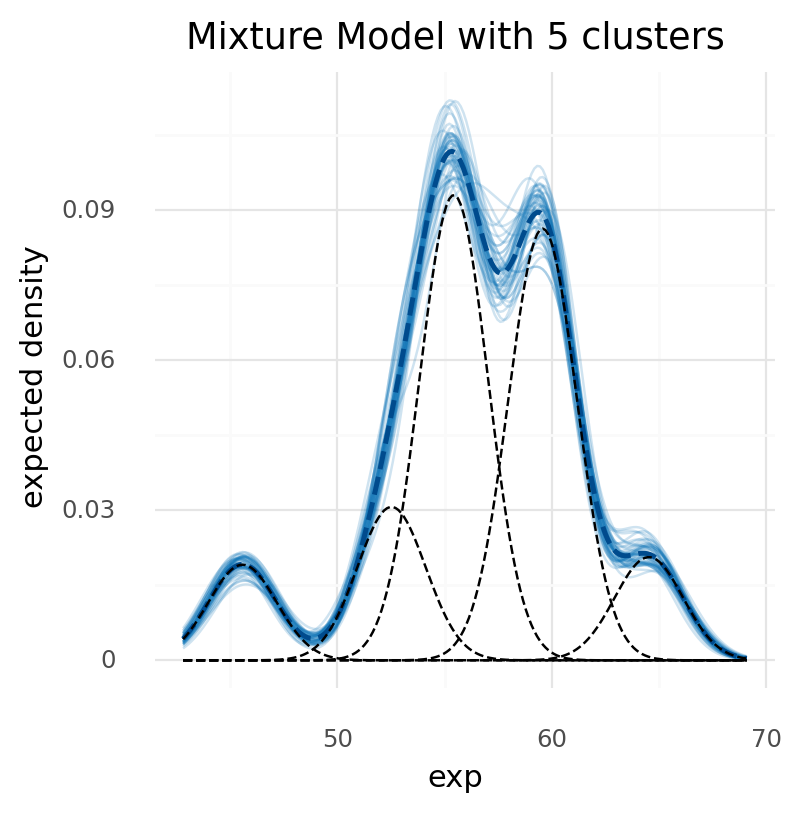

<ggplot: (8767960018303)>


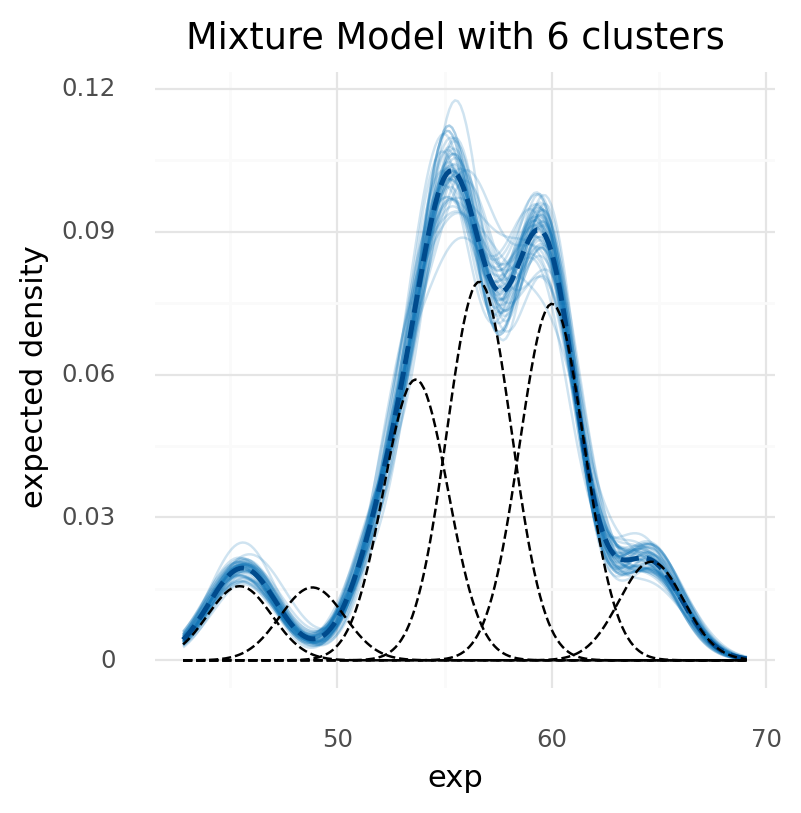

<ggplot: (8767959970726)>


In [83]:
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for n_clusters, trace in zip(clusters, traces):
    ppc_df = sample_ppcs(trace=trace, x=x, n_clusters=n_clusters)
    clusters_ppc_df = sample_ppc_per_cluster(trace=trace, x=x, n_clusters=n_clusters)
    print(plot_mixture_model_ppc(ppc_df, clusters_ppc_df, n_clusters))

In [85]:
mm_comparison = az.compare(dict(zip(clusters, traces)), method="BB-pseudo-BMA")
mm_comparison

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
6,0,-5127.827401,12.447644,0.000000,0.736916,32.738849,0.000000,False,log
5,1,-5129.245710,9.899071,1.418309,0.255827,32.235485,1.213311,False,log
4,2,-5139.433919,7.436035,11.606518,0.007257,31.838099,4.356708,False,log
3,3,-5178.648194,6.042494,50.820792,0.000000,31.791915,8.935154,False,log


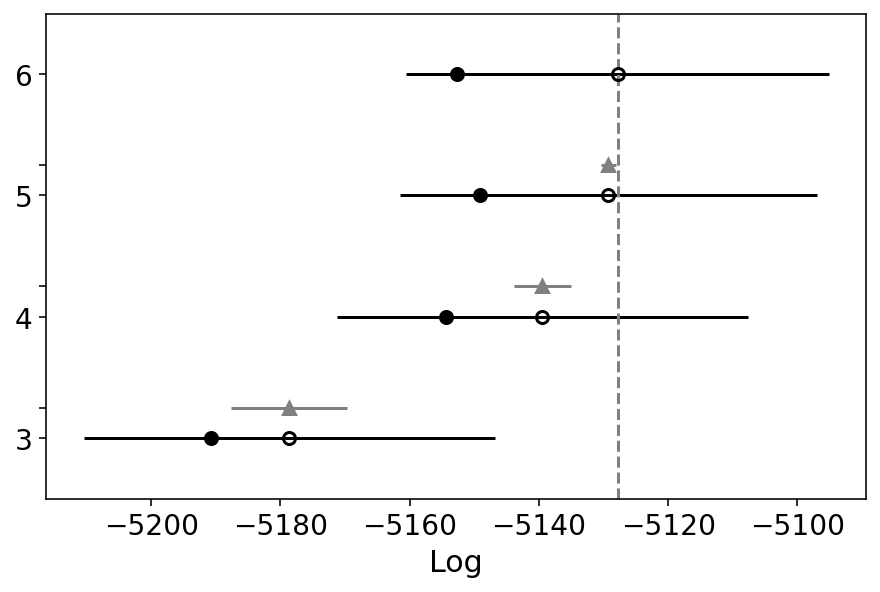

In [87]:
az.plot_compare(mm_comparison)
plt.show()

- from the above plots and table, the mixture model where $K=6$ appears to have the best fit (of the models tested)
    - there is considerable overlap between the models with $K=4, 5, 6$ in the LOO analysis

### Mixture models and clustering

---

In [12]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-04

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: master

pandas    : 1.2.0
plotnine  : 0.7.1
numpy     : 1.19.4
pymc3     : 3.9.3
scipy     : 1.6.0
seaborn   : 0.11.1
theano    : 1.0.5
arviz     : 0.10.0
matplotlib: 3.3.3

